In [ ]:
!pip install xgboost
!pip install -U scikit-learn
!pip install --upgrade --force-reinstall scikit-learn


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse


In [40]:
df = pd.read_csv("apartments_for_rent_classified_100K.csv", sep=";", encoding="latin1", low_memory=False)


In [84]:
df = df[df["price_type"] == "Monthly"].copy()
df["zip_code"] = df["body"].str.extract(r'\b(\d{5}(?:-\d{4})?)\b')
df["date"] = pd.to_datetime(df["time"], unit="s", errors="coerce")
df["studio_flag"] = df["title"].str.contains(r"\bstudio\b", flags=re.IGNORECASE).map({True: "Y", False: "N"})

df = df[
    df["price"].notna() &
    df["cityname"].notna() &
    df["state"].notna() &
    (df["amenities"].notna() & (df["amenities"] != "null")) &
    (df["bathrooms"].notna() & (df["bathrooms"] != "null")) &
    (df["bedrooms"].notna() & (df["bedrooms"] != "null")) &
    (df["square_feet"].notna() & (df["square_feet"] != "null")) &
    (df["pets_allowed"].notna() & (df["pets_allowed"] != "null"))
].copy()


df["zipcode"] = df["zip_code"].fillna("unknown")

cat_cols = [
    "fee", "has_photo", "pets_allowed", "price_type",
    "cityname", "state", "source", "zipcode", "studio_flag", "amenities"
]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")


33327
            id bathrooms bedrooms fee  has_photo pets_allowed   price  \
34  5668629745         1        1  No  Thumbnail    Cats,Dogs   975.0   
37  5668627517         1        1  No  Thumbnail    Cats,Dogs   975.0   
45  5668625536         1        1  No  Thumbnail    Cats,Dogs  1025.0   
46  5668625042         2        2  No  Thumbnail    Cats,Dogs  2548.0   
47  5668624921         2        3  No  Thumbnail    Cats,Dogs  1299.0   

    square_feet                     address      cityname state studio_flag  \
34          615        24625 Wilderness Oak   San Antonio    TX           N   
37          650            4092 Tpc Parkway   San Antonio    TX           N   
45          616      4320 North Towne Court       Windsor    WI           N   
46         1391          5235 Kester Avenue  Sherman Oaks    CA           N   
47         1119  5206 Moonlight Dr Trail SW       Concord    NC           N   

   zipcode  
34   24625  
37   78261  
45   53598  
46   91411  
47   28025  
in

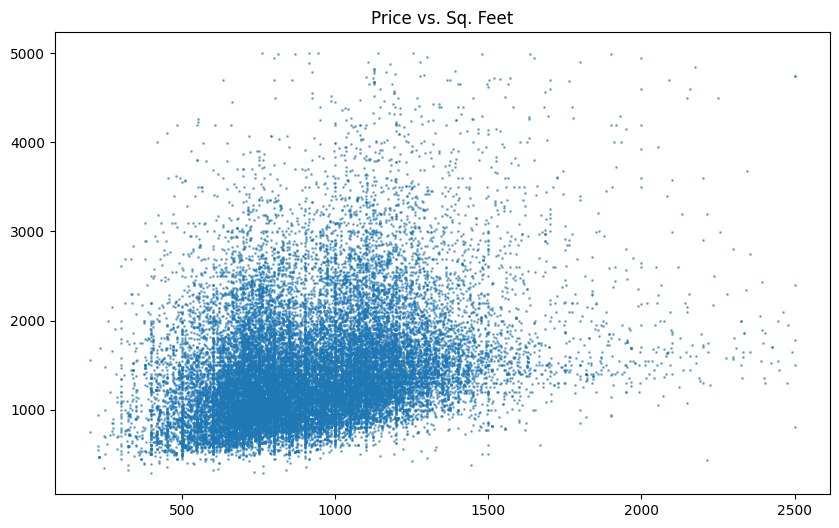

In [115]:
model_df = df.drop(columns=[
    "body", "source", "latitude", "longitude", "date", "time",
    "price_type", "title", "category", "amenities", "zip_code",
    "currency", "price_display"
], errors='ignore')

print(len(model_df))
model_df["square_feet"] = pd.to_numeric(model_df["square_feet"], errors="coerce")
model_df = model_df[
    (model_df["price"] <= 5000) &
    (model_df["square_feet"] <= 2500)
].copy()

print(model_df.head())
print(model_df["square_feet"].dtype)
print(len(model_df))

plt.figure(figsize = (10,6))
plt.scatter(model_df['square_feet'], model_df['price'], s=1, alpha=.5)
plt.title("Price vs. Sq. Feet")
plt.show()


y = model_df["price"]
X = model_df.drop(columns=["price"])

categorical_cols = X.select_dtypes(include='category').columns.tolist()
numeric_cols = X.select_dtypes(include='number').columns.tolist()


# Encode categorical
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = encoder.fit_transform(X[categorical_cols])

# Stack with numeric
X_num = X[numeric_cols].to_numpy()
X_sparse = sparse.hstack([X_cat, X_num])


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)


In [87]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=380,
    max_depth=10,
    learning_rate=0.8,
    verbosity=1
)
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [99]:
preds = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
#rmse = mean_squared_error(y_test, preds, squared=False)

print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")

importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
print("Keys in importance_dict:", list(importance_dict.keys())[:10])  # show sample



MAE: 183.74
Keys in importance_dict: ['f0', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']


['fee_No', 'fee_Yes', 'has_photo_No', 'has_photo_Thumbnail', 'has_photo_Yes', 'pets_allowed_Cats', 'pets_allowed_Cats,Dogs', 'pets_allowed_Dogs', 'cityname_Aberdeen', 'cityname_Abilene', 'cityname_Abingdon', 'cityname_Abington', 'cityname_Absecon', 'cityname_Acton', 'cityname_Acworth', 'cityname_Addison', 'cityname_Adelphi', 'cityname_Agoura Hills', 'cityname_Akron', 'cityname_Alameda', 'cityname_Albany', 'cityname_Albertville', 'cityname_Aledo', 'cityname_Alexandria', 'cityname_Alhambra', 'cityname_Aliquippa', 'cityname_Aliso Viejo', 'cityname_Allen', 'cityname_Allentown', 'cityname_Alliance', 'cityname_Allison Park', 'cityname_Allston', 'cityname_Alpharetta', 'cityname_Alpine', 'cityname_Altamonte Springs', 'cityname_Altoona', 'cityname_Alvin', 'cityname_Amelia', 'cityname_Ames', 'cityname_Anaheim', 'cityname_Anchorage', 'cityname_Anderson', 'cityname_Andover', 'cityname_Ann Arbor', 'cityname_Anna', 'cityname_Annandale', 'cityname_Annapolis', 'cityname_Anniston', 'cityname_Anoka', 'c

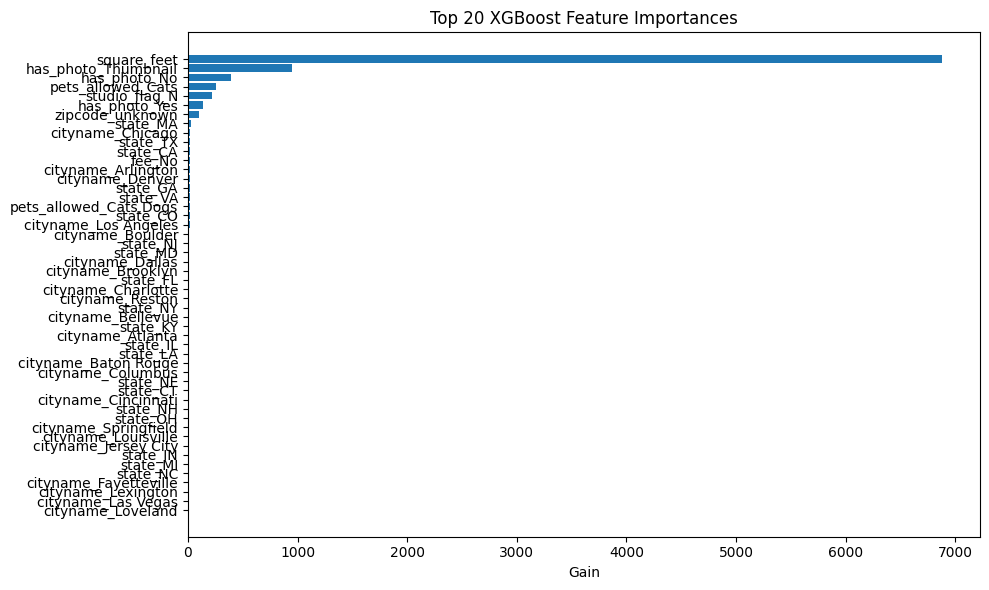

In [112]:
# Get categorical feature names from encoder
cat_feature_names = encoder.get_feature_names_out(categorical_cols)
#print(cat_feature_names)

# Combine with numeric feature names
all_feature_names = list(cat_feature_names) + numeric_cols
print(all_feature_names)

# Get raw feature importances (by gain)
importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
print(importance_dict) 

# Map XGBoost's 'f0', 'f1', ... to real feature names
mapped_importance = {
    all_feature_names[int(k[1:])]: v
    for k, v in importance_dict.items()
    if k.startswith("f") and int(k[1:]) < len(all_feature_names)
}
print(mapped_importance)

# Convert to DataFrame and plot top 20
importances = pd.DataFrame(mapped_importance.items(), columns=["Feature", "Importance"])
print(importances)
importances = importances.sort_values(by="Importance", ascending=False)
print(importances)

plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"][:50][::-1], importances["Importance"][:50][::-1])
plt.xlabel("Gain")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

